## Find PACE and EMIT granules overlapping in time and space
Adapted from VITALS "Finding Concurrent ECOSTRESS and EMIT Data" tutorial located [here](https://nasa.github.io/VITALS/python/01_Finding_Concurrent_Data.html).

Adapted for PACE by: Skye Caplan (NASA, SSAI)

Last updated: 01/06/2026

<div class="alert alert-info" role="alert">

An [Earthdata Login][edl] account is required to access data from the NASA Earthdata system, including NASA PACE and EMIT data.

</div>

[edl]: https://urs.earthdata.nasa.gov/
[oci-data-access]: https://oceancolor.gsfc.nasa.gov/resources/docs/tutorials/notebooks/oci_data_access/
[emit-data-access]: https://nasa.github.io/VITALS/python/Exploring_EMIT_L2A_RFL.html

## Summary

This notebook will use `earthacces` and metadata in EMIT and PACE files' attributes to find overlapping granules both in space and within a certain time interval. 

## Learning Objectives

At the end of this notebook, you will know how to:
- Search for both PACE and EMIT data
- Filter those search results to find concurrent datasets based on overpass time, cloud cover, etc.
- Download only the datasets which match your filter criteria. 

## Contents
1. [Setup](#1.-Setup)
2. [Filtering Data](#2.-Filtering-Data)
3. [Download or Stream Data](#3.-Download-or-Stream-Data)


## 1. Setup

Begin by importing all of the packages used in this notebook. PACE OCI has many data products.

In [1]:
import utils
import os
import folium
import earthaccess
import warnings
import folium.plugins
import pandas as pd
import geopandas as gpd
import numpy as np 

from branca.element import Figure
from IPython.display import display
from shapely import geometry
from skimage import io
from datetime import timedelta
from shapely.geometry.polygon import orient
from matplotlib import pyplot as plt

The following cells use `earthaccess` to set and persist your Earthdata login credentials, then define parameters to begin our search for data. We define a timespan, a region of interest (ROI), and the products we are looking for. In this example, we will work on finding concurrent reflectance data for both sensors. 

Note that there are two PACE product suites listed in the `prods` list, one with and one without `NRT` at the end. `NRT` stands for Near Real Time, which is the collection that any recent data (~1-2 months from present day) will fall into. The other suite is for Refined data, which has been reprocessed with the best available ancillary data. More information can be found in the [SFREFL ATBD](https://www.earthdata.nasa.gov/apt/documents/sfrefl/v1.0).

In [2]:
auth = earthaccess.login(persist=True)

This tutorial series is going to use the January 2025 LA fires to demonstrate the complementary us of PACE and EMIT data. We'll be using the difference in normalized burn ratio (dNBR) to analyze the burn severity, which is defined as DEFINE THIS BELOW.

Let's find some granules from both missions which capture the affected areas. We know that these two instruments are on very different orbits and have very different data collection timelines - PACE will have a granule over whatever bounding box we provide once per day, while EMIT's coverage will be finer but much more sparse. We could try to look for scenes from the two missions that overlap in time as well as space, but that would most likely not optimize our analysis for the characteristics of both imagers. dNBR only needs scenes from ~1-2 months before and after the fire event, so all we have to do is make sure our granules cover the affected areas. 

In [3]:
# Set up search params for datasets
# Time ~ 1 month before and after the fires, roi of LA
tspan = ('2024-09-01','2025-04-01')
roi_bounds = (-119.5, 33.5, -117, 34.5)

bbox = geometry.box(*roi_bounds, ccw=True)
roi = list(bbox.exterior.coords)
gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[bbox])

# Names of products to search
prods = ["PACE_OCI_L2_SFREFL", "EMITL2ARFL"]

In [4]:
# Grab results from Earthdata
results = earthaccess.search_data(
    short_name=prods,
    polygon=roi,
    temporal=tspan,
    count=500
)

len(results)

311

We can run the results of our search, and see that we gathered ~100 granules for this case. We need to filter them down for things like cloud cover, temporal proximity to fires, angle, etc. We also want to see how they overlap. Let's try some filtering for the latter:

## 2. Filtering Data

In [5]:
# Create Dataframe of Results Metadata
results_df = pd.json_normalize(results)
# Create shapely polygons for result
geometries = [utils.get_shapely_object(results[index]) for index in results_df.index.to_list()]
# Convert to GeoDataframe
gdf = gpd.GeoDataFrame(results_df, geometry=geometries, crs="EPSG:4326")
# Remove results df, no longer needed
del results_df
# Add browse imagery links
gdf['browse'] = [utils.get_png(granule) for granule in results]
gdf['shortname'] = [result['umm']['CollectionReference']['ShortName'] for result in results]
# Preview GeoDataframe
print(f'{gdf.shape[0]} granules total')

311 granules total


In [6]:
# Create a list of columns to keep
keep_cols = ['meta.concept-id','meta.native-id', 'umm.TemporalExtent.RangeDateTime.BeginningDateTime',
             'umm.TemporalExtent.RangeDateTime.EndingDateTime','umm.CloudCover','umm.DataGranule.DayNightFlag',
             'geometry','browse', 'shortname']
# Remove unneeded columns
gdf = gdf[gdf.columns.intersection(keep_cols)]
# Rename some Columns
gdf.rename(columns = {'meta.concept-id':'concept_id','meta.native-id':'granule',
                       'umm.TemporalExtent.RangeDateTime.BeginningDateTime':'start_datetime',
                      'umm.TemporalExtent.RangeDateTime.EndingDateTime':'end_datetime',
                      'umm.CloudCover':'cloud_cover',
                      'umm.DataGranule.DayNightFlag':'day_night'}, inplace=True)
gdf['datetime_obj'] = pd.to_datetime(gdf['start_datetime'], format='ISO8601')

In [7]:
gdf.head()

concept_id                                       granule  \
0  G3705261057-LPCLOUD  EMIT_L2A_RFL_001_20241005T173911_2427912_002   
1  G3281400658-LPCLOUD  EMIT_L2A_RFL_001_20241005T173923_2427912_003   
2  G3281403830-LPCLOUD  EMIT_L2A_RFL_001_20241005T173935_2427912_004   
3  G3270059831-LPCLOUD  EMIT_L2A_RFL_001_20241018T201303_2429213_004   
4  G3270061174-LPCLOUD  EMIT_L2A_RFL_001_20241018T201315_2429213_005   

         start_datetime          end_datetime  cloud_cover day_night  \
0  2024-10-05T17:39:11Z  2024-10-05T17:39:23Z         99.0       Day   
1  2024-10-05T17:39:23Z  2024-10-05T17:39:35Z         13.0       Day   
2  2024-10-05T17:39:35Z  2024-10-05T17:39:47Z          5.0       Day   
3  2024-10-18T20:13:03Z  2024-10-18T20:13:15Z         99.0       Day   
4  2024-10-18T20:13:15Z  2024-10-18T20:13:26Z         99.0       Day   

                                            geometry  \
0  POLYGON ((-119.65976 34.68674, -120.42937 34.0...   
1  POLYGON ((-119.00515 35.19704, -119.7875 34.58...   
2  POLYGON ((-118.33995 35.70409, -119.14003 35.0...   
3  POLYGON ((-119.61501 34.08108, -120.11467 33.4...   
4  POLYGON ((-118.97923 33.56248, -119.48437 32.9...   

                                              browse   shortname  \
0  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL   
1  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL   
2  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL   
3  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL   
4  https://data.lpdaac.earthdatacloud.nasa.gov/lp...  EMITL2ARFL   

               datetime_obj  
0 2024-10-05 17:39:11+00:00  
1 2024-10-05 17:39:23+00:00  
2 2024-10-05 17:39:35+00:00  
3 2024-10-18 20:13:03+00:00  
4 2024-10-18 20:13:15+00:00

### Combine all cells below for e.g. do filtering all at once

In [8]:
# Suppress Setting with Copy Warning - not applicable in this use case
pd.options.mode.chained_assignment = None  # default='warn'

# Split into two dataframes - ECO and EMIT
pace_gdf = gdf[gdf['granule'].str.contains('OCI')]
emit_gdf = gdf[gdf['granule'].str.contains('EMIT')]
print(f' PACE OCI Granules: {pace_gdf.shape[0]} \n EMIT Granules: {emit_gdf.shape[0]}')

 PACE OCI Granules: 285 
 EMIT Granules: 26


In [9]:
# Subset PACE Granules in Geodataframe by intersection with EMIT granules
## Create new column based on intersection with union of EMIT polygons.
pace_gdf['intersects'] = pace_gdf.intersects(emit_gdf.union_all())
## Apply subsetting
pace_gdf = pace_gdf[pace_gdf['intersects'] == True]
print(f' PACE OCI Granules: {pace_gdf.shape[0]} \n EMIT Granules: {emit_gdf.shape[0]}')

 PACE OCI Granules: 285 
 EMIT Granules: 26


In [10]:
pace_gdf, emit_gdf = utils.concurrent_match(pace_gdf,emit_gdf, col_name='datetime_obj',time_delta=timedelta(days=3))
print(f' PACE OCI Granules: {pace_gdf.shape[0]} \n EMIT Granules: {emit_gdf.shape[0]}')

 PACE OCI Granules: 59 
 EMIT Granules: 26


And now we can plot our very reduced list of granules to see what we're left with. We want to make sure the PACE and EMIT granules we select have optimal conditions within themselves (e.g., clouds, no bad data, etc.), but also between sensors as well. EMIT granules are much smaller than one PACE OCI scene, and it's possible some of the EMIT data in our filtered list could overlap with PACE OCI at the edge of its swath, where L2 OCI pixels are expected to have greater angular effects. To minimize these effects, it's preferable to choose EMIT granules closer to the centre of an OCI scene, which the Folium map below is very useful for determining. 

In [11]:
# Plot Using Folium
# Function to convert a bounding box for use in leaflet notation

# Create Figure and Select Background Tiles
fig = Figure(width="750px", height="375px")
map1 = folium.Map(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', attr='Google')
fig.add_child(map1)

# Plot STAC ECOSTRESS Results - note we must drop the datetime_obj columns for this to work
pace_gdf.drop(columns=['datetime_obj']).explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "start_datetime",
        "cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="PACE OCI",
    m=map1,
    legend=False
)

# Plot STAC EMITL2ARFL Results - note we must drop the datetime_obj columns for this to work
emit_gdf.drop(columns=['datetime_obj']).explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "start_datetime",
        "cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="EMIT",
    m=map1,
    legend=False
)


folium.GeoJson(bbox,
                name='bounding_box',
                ).add_to(map1)

map1.fit_bounds(bounds=utils.convert_bounds(gdf.union_all().bounds))
map1.add_child(folium.LayerControl())
display(fig)

We can see that there are 3 and 5 PACE and EMIT granules, respectively. Though they technically overlap, The EMIT granules do not cover the area affected by the fires in this time range. We're going to have to broaden our search parameters. Since the goal of this tutorial series is to 

As mentioned above, we also want to make sure the data isn't filled with NaNs. From the map, it looks like January 17th is a good day for both EMIT and PACE, and the EMIT granules are relatively close to centre swath. We can print out the browse imagery for that day and decide which EMIT granules to keep for our final stream/download. 

PACE OCI browse imagery is coming soon, and once available, we will be able to quickly visualize the imagery in the same way to ensure initial data quality. 

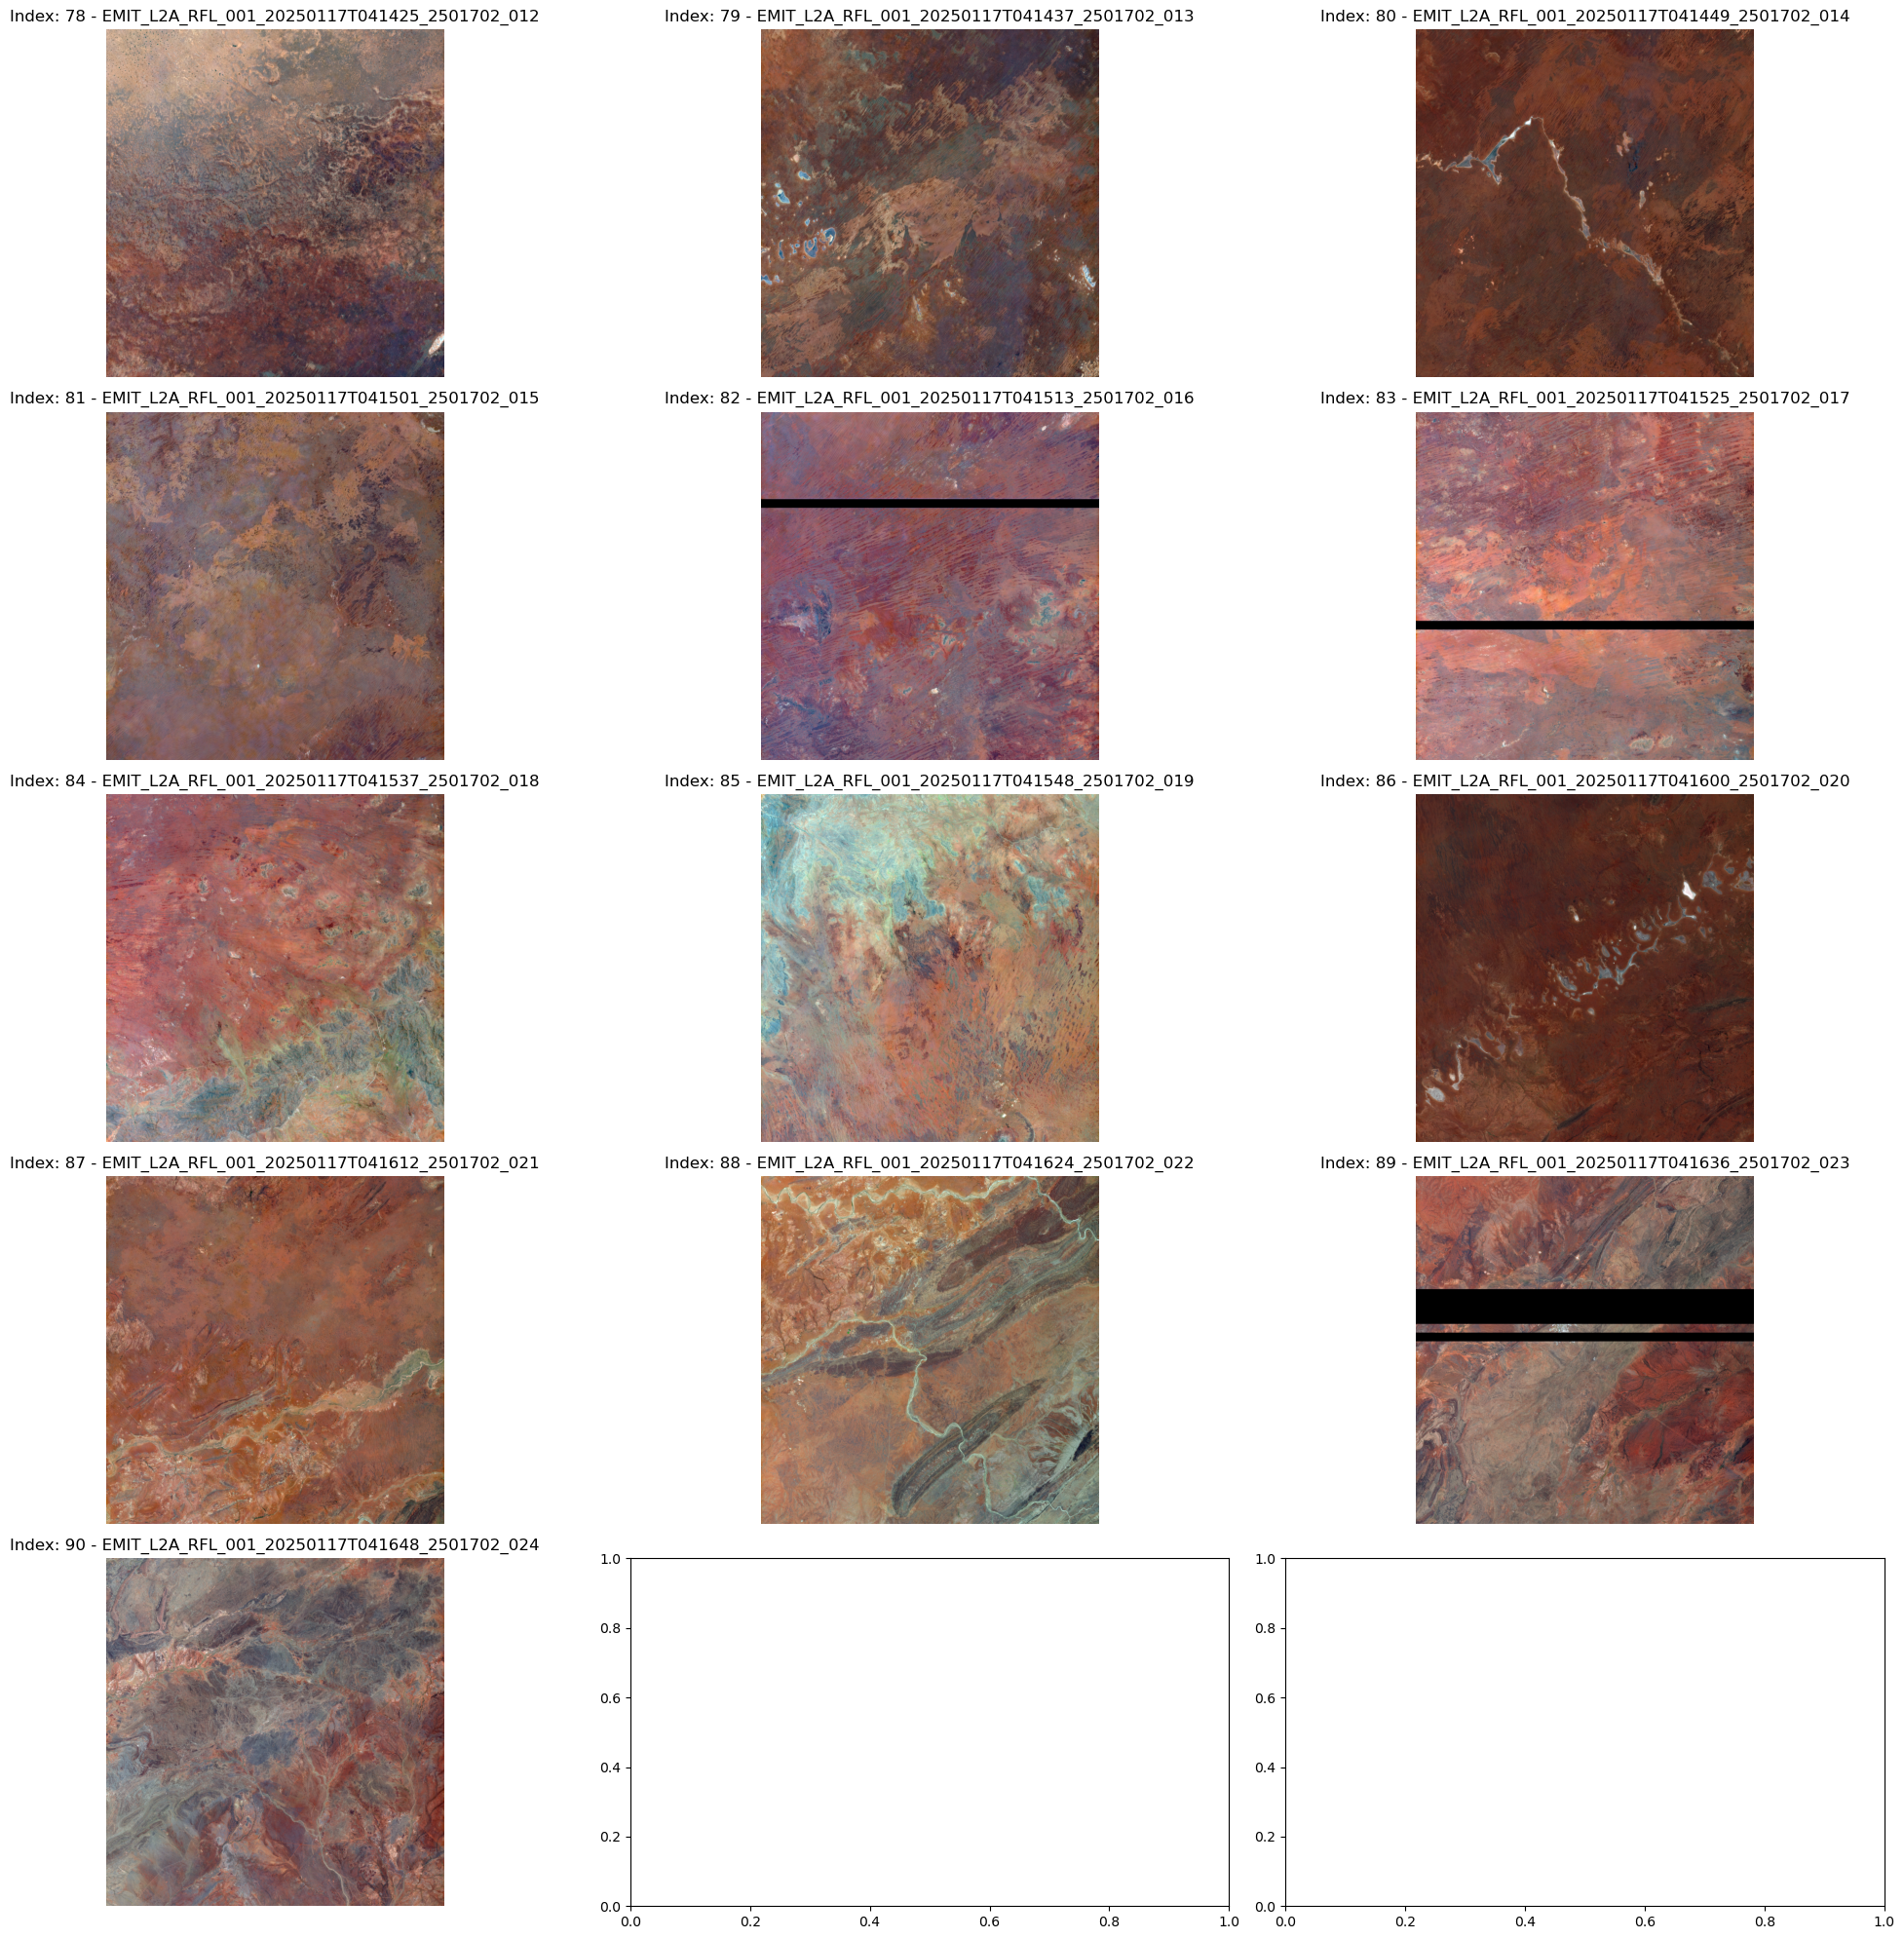

In [26]:
# filter by granule
pace_0117 = pace_gdf[(pace_gdf['granule'].str.contains("20250117T044314")) & ~(pace_gdf['granule'].str.contains("NRT"))]
emit_0117 = emit_gdf[emit_gdf['granule'].str.contains("20250117")]

cols = 3
rows = int(np.ceil(len(emit_0117)/cols))
fig, ax = plt.subplots(rows, cols, figsize=(20,20))
ax = ax.flatten()

for _n, index in enumerate(emit_0117.index.to_list()):
    img = io.imread(emit_0117['browse'][index])
    ax[_n].imshow(img)
    ax[_n].set_title(f"Index: {index} - {emit_0117['granule'][index]}")
    ax[_n].axis('off')
plt.tight_layout()
plt.show()


We'll keep 2 granules from the above selection, and put them in a final `filtered_results` list

In [52]:
# Filter out granules to keep
good_grans = [80, 81] # 5 for if we want an expanded set [78,80,81,87,90] # Index numbers
emit_0117_grans = emit_0117[emit_0117.index.isin(good_grans)]
keep_granules = pace_0117.index.to_list()+emit_0117_grans.index.to_list()
keep_granules.sort()

filtered_results = [result for i, result in enumerate(results) if i in keep_granules]
filtered_results

[Collection: {'ShortName': 'EMITL2ARFL', 'Version': '001'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 129.06637573242188, 'Latitude': -28.02098846435547}, {'Longitude': 128.42047119140625, 'Latitude': -28.64733123779297}, {'Longitude': 128.97866821289062, 'Latitude': -29.222972869873047}, {'Longitude': 129.62457275390625, 'Latitude': -28.596630096435547}, {'Longitude': 129.06637573242188, 'Latitude': -28.02098846435547}]}}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2025-01-17T04:14:49Z', 'EndingDateTime': '2025-01-17T04:15:01Z'}}
 Size(MB): 3579.4740257263184
 Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20250117T041449_2501702_014/EMIT_L2A_RFL_001_20250117T041449_2501702_014.nc', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20250117T041449_2501702_014/EMIT_L2A_RFLUNCERT_001_20250117T04144

## 3. Download or Stream Data

Now that we have all the links for the data we want, we can either stream or download the files, depending on user preference. 

In [53]:
# Grab only the reflectance data for the EMIT Granules
# TODO: Better way to do this?
files = [filtered_results[i].data_links(access="external")[0] for i in range(len(filtered_results)-1)]

# Add the PACE file to the end
files.append(filtered_results[-1].data_links(access="external")[0])
files

# Download with earthaccess
#files = [filtered_results[1],filtered_results[2], filtered_results[-1]]
paths = earthaccess.download(files, local_path="data")
#paths = earthaccess.open(files)

#results_urls = [granule.data_links() for granule in filtered_results]
#results_urls

QUEUEING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

Now the datasets are downloaded! Please proceed to the next tutorial in this series to learn how to open, explore, and regrid the scenes. 